## Generating Benchmark Data for Wikipedia Dataset

The data is taken from the [Web Traffic Time Series Forecasting
](https://www.kaggle.com/competitions/web-traffic-time-series-forecasting/overview) challenge on Kaggle, a research competiton organized by Google ($25,000).

In [12]:
ROOT = "/data/cmu/large-scale-hts-reconciliation/"
data_dir = ROOT + "notebooks/"

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from tqdm import tqdm

In [14]:
df = pd.read_csv(data_dir + 'train_1.csv').fillna(0)
df

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145058,Underworld_(serie_de_películas)_es.wikipedia.o...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,13.0,12.0,13.0,3.0,5.0,10.0
145059,Resident_Evil:_Capítulo_Final_es.wikipedia.org...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
145060,Enamorándome_de_Ramón_es.wikipedia.org_all-acc...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
145061,Hasta_el_último_hombre_es.wikipedia.org_all-ac...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Forecasting is done on a separate file. Here's what it roughly looks like.

```python
import dask.dataframe as dd

ddf = dd.from_pandas(df, npartitions=120) # over-subscribing

forecast_horizon = 100

def predict(row):
    data = pd.DataFrame({'ds': (row.index)[1:][-forecast_horizon:], 'y':(row.values)[1:][-forecast_horizon:]})
    m = Prophet()
    m.fit(data)
    
    future = m.make_future_dataframe(periods=forecast_horizon)
    future.tail()
    forecast = m.predict(future)

    return row.Page, forecast[['yhat']][-forecast_horizon:].values.reshape(-1)
```

### Sanity check by plotting

In [15]:
import pickle
predictions = pickle.load(open(data_dir + 'wikipedia_time_series_prediction_raw/result.pkl', 'rb'))

SMAPE:  69.803


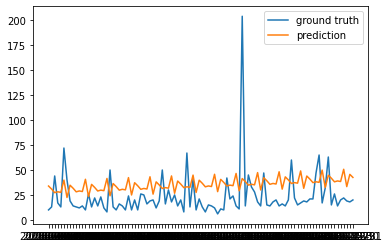

In [16]:
import seaborn as sns

def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

pred = predictions[0][1]
index = list(df.columns)[1:][-100:]
gt = df.iloc[0,:].values[-100:]

sns.lineplot(x=index, y=gt, label='ground truth')
sns.lineplot(x=index, y=pred, label='prediction')

print("SMAPE: ", smape(gt, pred).round(3))

### Export trace for benchmarking 

In [17]:
time_index = index
disagg = []

for p, (i, g) in tqdm(zip(predictions, df.iterrows()), total = len(df)):
    assert(p[0] == g.Page)
    disagg.append((g.Page, p[1], g.values[-100:]))

100%|█████████████████████████████████████████| 145063/145063 [00:12<00:00, 11524.52it/s]


In [18]:
node_id_mapping = {'node_id': [], 'name': []}

pred_tensor = np.zeros((len(disagg), 100))
gt_tensor = np.zeros((len(disagg), 100))

for i, (name, prediction, gt) in tqdm(enumerate(disagg)):
    pred_tensor[i, :] = prediction
    gt_tensor[i, :] = gt
    node_id_mapping['node_id'].append(i)
    node_id_mapping['name'].append(name)

145063it [00:01, 124785.98it/s]


### Compiling the hierarchies

In [19]:
node_id_map_df = pd.DataFrame(node_id_mapping)

In [20]:
node_id_map_df['level_4'] = node_id_map_df['name']
node_id_map_df['level_3'] = node_id_map_df['name'].apply(lambda x: '_'.join(x.split('_')[:-1]))
node_id_map_df['level_2'] = node_id_map_df['name'].apply(lambda x: '_'.join(x.split('_')[:-2]))
node_id_map_df['level_1'] = node_id_map_df['name'].apply(lambda x: x.split('_')[-3])

In [21]:
parent_node_mapping = {'node_id': [], 'name': []}

level3 = list(set(node_id_map_df['level_3'].values))
level2 = list(set(node_id_map_df['level_2'].values))
level1 = list(set(node_id_map_df['level_1'].values))

curr_sum = len(node_id_map_df)

for s in [level3, level2, level1]:
    for i, v in enumerate(s):
        parent_node_mapping['node_id'].append(i + curr_sum)
        parent_node_mapping['name'].append(v)
    curr_sum += len(s)

In [22]:
parent_node_mapping_df = pd.DataFrame(parent_node_mapping)

In [36]:
node_id_map_df.to_csv(data_dir + 'wikipedia_time_series_prediction_raw/node_id_map.csv', index=False)
parent_node_mapping_df.to_csv(data_dir + 'wikipedia_time_series_prediction_raw/parent_node_id_map.csv', index=False)

In [37]:
pickle.dump(time_index, open(data_dir + 'wikipedia_time_series_prediction_raw/time_index.pkl', 'wb'))
np.save(open(data_dir + 'wikipedia_time_series_prediction_raw/pred_tensor.npy', 'wb'), pred_tensor)
np.save(open(data_dir + 'wikipedia_time_series_prediction_raw/gt_tensor.npy', 'wb'), gt_tensor)

In [25]:
from collections import Counter
Counter(node_id_map_df.level_1.values)

Counter({'zh.wikipedia.org': 17229,
         'fr.wikipedia.org': 17802,
         'en.wikipedia.org': 24108,
         'commons.wikimedia.org': 10555,
         'ru.wikipedia.org': 15022,
         'www.mediawiki.org': 7300,
         'de.wikipedia.org': 18547,
         'ja.wikipedia.org': 20431,
         'es.wikipedia.org': 14069})

In [26]:
node_id_map_df.level_4.values

array(['2NE1_zh.wikipedia.org_all-access_spider',
       '2PM_zh.wikipedia.org_all-access_spider',
       '3C_zh.wikipedia.org_all-access_spider', ...,
       'Enamorándome_de_Ramón_es.wikipedia.org_all-access_spider',
       'Hasta_el_último_hombre_es.wikipedia.org_all-access_spider',
       'Francisco_el_matemático_(serie_de_televisión_de_2017)_es.wikipedia.org_all-access_spider'],
      dtype=object)

### Format to Nixtla standard

In [27]:
tags = {}
tags['level_1'] = node_id_map_df.level_1.unique()
tags['level_2'] = node_id_map_df.level_2.unique()
tags['level_3'] = node_id_map_df.level_3.unique()
tags['level_4'] = node_id_map_df.level_4.unique()

In [28]:
tags

{'level_1': array(['zh.wikipedia.org', 'fr.wikipedia.org', 'en.wikipedia.org',
        'commons.wikimedia.org', 'ru.wikipedia.org', 'www.mediawiki.org',
        'de.wikipedia.org', 'ja.wikipedia.org', 'es.wikipedia.org'],
       dtype=object),
 'level_2': array(['2NE1_zh.wikipedia.org', '2PM_zh.wikipedia.org',
        '3C_zh.wikipedia.org', ...,
        'Eine_Reihe_betrüblicher_Ereignisse_(Fernsehserie)_de.wikipedia.org',
        'ジャック・リーチャー_ja.wikipedia.org', 'マイク眞木_ja.wikipedia.org'],
       dtype=object),
 'level_3': array(['2NE1_zh.wikipedia.org_all-access',
        '2PM_zh.wikipedia.org_all-access',
        '3C_zh.wikipedia.org_all-access', ...,
        '学校法人森友学園_ja.wikipedia.org_all-access',
        'Discussion:Scintillation_fr.wikipedia.org_all-access',
        'xss_ja.wikipedia.org_all-access'], dtype=object),
 'level_4': array(['2NE1_zh.wikipedia.org_all-access_spider',
        '2PM_zh.wikipedia.org_all-access_spider',
        '3C_zh.wikipedia.org_all-access_spider', ...,
    

In [29]:
y_gt = {'unique_id': [], 'ds': [], 'y': []}
y_hat = {'unique_id': [], 'ds': [], 'y': []}

for _, ro in tqdm(node_id_map_df.iterrows()):
    for i in range(100):
        y_gt['unique_id'].append(ro.name)
        y_gt['ds'].append(time_index[i])
        y_gt['y'].append(gt_tensor[ro.node_id, i])
        
        y_hat['unique_id'].append(ro.name)
        y_hat['ds'].append(time_index[i])
        y_hat['y'].append(pred_tensor[ro.node_id, i])

145063it [03:55, 616.15it/s]


In [30]:
Y_gt = pd.DataFrame(y_gt)

In [31]:
Y_hat = pd.DataFrame(y_hat)

In [32]:
Y_hat.rename(columns = {'y': 'prophet'}, inplace=True)

In [33]:
Y_gt.to_csv(data_dir + 'wikipedia_time_series_prediction_raw/nixtla_y_gt.csv', index=False)
Y_hat.to_csv(data_dir + 'wikipedia_time_series_prediction_raw/nixtla_y_hat.csv', index=False)

In [34]:
import gc
nrow = len(tags['level_1']) + len(tags['level_2']) + len(tags['level_3']) + len(tags['level_4'])
ncol = len(tags['level_4'])

columns = list(tags['level_4'])
rows = list(tags['level_1']) + list(tags['level_2']) + list(tags['level_3']) + list(tags['level_4'])

We will see that the naive method will consume too much memory to even store the S matrix.
```
---------------------------------------------------------------------------
MemoryError                               Traceback (most recent call last)
/tmp/ipykernel_24000/2646015648.py in <module>
----> 1 raw_S = np.zeros((nrow, ncol)).astype(float)

MemoryError: Unable to allocate 333. GiB for an array with shape (308004, 145063) and data type float64
```

In [35]:
raw_S = np.zeros((nrow, ncol)).astype(float) # this OOMs

MemoryError: Unable to allocate 333. GiB for an array with shape (308004, 145063) and data type float64